### Importing necesary dependencies

In [1]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Input, Dense, Dropout

from glob import glob
import os
import gc
import random
import cv2
import yaml
import numpy as np
from sklearn.utils import shuffle
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Using TensorFlow backend.


## Getting Data

### Image paths and labels

In [2]:
img_paths = []
labels = []

### Getting Data from simulator

In [3]:
SIM_DATA_DIR = os.path.join('data', 'sim')

sim_file_paths_green = glob(os.path.join(SIM_DATA_DIR, 'green*', '*.png'))
sim_file_paths_yellow = glob(os.path.join(SIM_DATA_DIR, 'yellow*', '*.png'))
sim_file_paths_red = glob(os.path.join(SIM_DATA_DIR, 'red*', '*.png'))
sim_file_paths_none = glob(os.path.join(SIM_DATA_DIR, 'none*', '*.png'))
print('From Simulator - Green: {}, Yellow: {}, Red: {}, None: {}'.format(
    len(sim_file_paths_green), len(sim_file_paths_yellow), len(sim_file_paths_red), len(sim_file_paths_none)))

From Simulator - Green: 928, Yellow: 320, Red: 1176, None: 2219


In [4]:
sim_file_paths_green = shuffle(sim_file_paths_green)[:900]
sim_file_paths_yellow = shuffle(sim_file_paths_yellow)[:300]
sim_file_paths_red = shuffle(sim_file_paths_red)[:900]
sim_file_paths_none = shuffle(sim_file_paths_none)[:1800]
print('From Simulator - Green: {}, Yellow: {}, Red: {}, None: {}'.format(
    len(sim_file_paths_green), len(sim_file_paths_yellow), len(sim_file_paths_red), len(sim_file_paths_none)))

From Simulator - Green: 900, Yellow: 300, Red: 900, None: 1800


In [5]:
img_paths.extend(sim_file_paths_green)
labels.extend([[1.0, 0.0, 0.0, 0.0] for i in range(len(sim_file_paths_green))])

img_paths.extend(sim_file_paths_yellow)
labels.extend([[0.0, 1.0, 0.0, 0.0] for i in range(len(sim_file_paths_yellow))])

img_paths.extend(sim_file_paths_red)
labels.extend([[0.0, 0.0, 1.0, 0.0] for i in range(len(sim_file_paths_red))])

img_paths.extend(sim_file_paths_none)
labels.extend([[0.0, 0.0, 0.0, 1.0] for i in range(len(sim_file_paths_none))])

In [6]:
print('No. images: {}, No. Labels: {}'.format(len(img_paths), len(labels)))

No. images: 3900, No. Labels: 3900


### Getting Data from rosbags

In [7]:
DATA_DIR = 'data'

rosbag_file_paths = [[], [], [], []]

for sample_dir in ['rosbag', 'ext_rosbag', 'rosbag1', 'ext_rosbag1', 'rosbag2', 'ext_rosbag2']: 
    for color, color_dir in enumerate(['green', 'yellow', 'red', 'none']):
        full_color_dir = os.path.join(DATA_DIR, sample_dir, color_dir)
        paths = glob(os.path.join(full_color_dir, '*.jpg'))
        rosbag_file_paths[color].extend(paths)
        print('Processed: {}, no. images {}, color: {}'.format(full_color_dir, len(paths), color))

print('From Rosbags - Green: {}, Yellow: {}, Red: {}, None: {}'.format(
    len(rosbag_file_paths[0]), len(rosbag_file_paths[1]), len(rosbag_file_paths[2]), len(rosbag_file_paths[3])))

Processed: data/rosbag/green, no. images 318, color: 0
Processed: data/rosbag/yellow, no. images 217, color: 1
Processed: data/rosbag/red, no. images 379, color: 2
Processed: data/rosbag/none, no. images 273, color: 3
Processed: data/ext_rosbag/green, no. images 318, color: 0
Processed: data/ext_rosbag/yellow, no. images 217, color: 1
Processed: data/ext_rosbag/red, no. images 379, color: 2
Processed: data/ext_rosbag/none, no. images 273, color: 3
Processed: data/rosbag1/green, no. images 120, color: 0
Processed: data/rosbag1/yellow, no. images 59, color: 1
Processed: data/rosbag1/red, no. images 105, color: 2
Processed: data/rosbag1/none, no. images 473, color: 3
Processed: data/ext_rosbag1/green, no. images 120, color: 0
Processed: data/ext_rosbag1/yellow, no. images 59, color: 1
Processed: data/ext_rosbag1/red, no. images 105, color: 2
Processed: data/ext_rosbag1/none, no. images 473, color: 3
Processed: data/rosbag2/green, no. images 121, color: 0
Processed: data/rosbag2/yellow, no

In [8]:
rosbag_file_paths_green = shuffle(rosbag_file_paths[0])[:900]
rosbag_file_paths_yellow = shuffle(rosbag_file_paths[1])[:600]
rosbag_file_paths_red = shuffle(rosbag_file_paths[2])[:900]
rosbag_file_paths_none = shuffle(rosbag_file_paths[3])[:1800]
print('From Rosbags - Green: {}, Yellow: {}, Red: {}, None: {}'.format(
    len(rosbag_file_paths_green), len(rosbag_file_paths_yellow), len(rosbag_file_paths_red), len(rosbag_file_paths_none)))

From Rosbags - Green: 900, Yellow: 600, Red: 900, None: 1800


In [9]:
img_paths.extend(rosbag_file_paths_green)
labels.extend([[1.0, 0.0, 0.0, 0.0] for i in range(len(rosbag_file_paths_green))])

img_paths.extend(rosbag_file_paths_yellow)
labels.extend([[0.0, 1.0, 0.0, 0.0] for i in range(len(rosbag_file_paths_yellow))])

img_paths.extend(rosbag_file_paths_red)
labels.extend([[0.0, 0.0, 1.0, 0.0] for i in range(len(rosbag_file_paths_red))])

img_paths.extend(rosbag_file_paths_none)
labels.extend([[0.0, 0.0, 0.0, 1.0] for i in range(len(rosbag_file_paths_none))])

In [10]:
print('No. images: {}, No. Labels: {}'.format(len(img_paths), len(labels)))

No. images: 8100, No. Labels: 8100


### Combined training and test (validation) sets

In [11]:
img_paths, labels = shuffle(img_paths, labels)

print('Total - imgs: {}, labels: {}'.format(len(img_paths), len(labels)))


img_paths_train, img_paths_test, labels_train, labels_test = train_test_split(img_paths, labels, test_size=0.2)

print('Train - imgs: {}, labels: {}'.format(len(img_paths_train), len(labels_train)))
print('Test - imgs: {}, labels: {}'.format(len(img_paths_test), len(labels_test)))

Total - imgs: 8100, labels: 8100
Train - imgs: 6480, labels: 6480
Test - imgs: 1620, labels: 1620


### Testing training/validation sets

Image Path: data/ext_rosbag/green/frame0278.jpg
Image Shape: (224, 224, 3)
Image Label: [1.0, 0.0, 0.0, 0.0]
Image Class: green


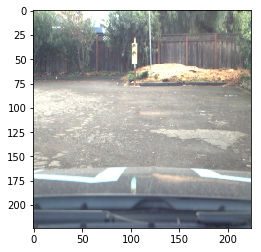

In [12]:
i = (int)(random.random() * len(img_paths))
img_path = img_paths[i]
print('Image Path: {}'.format(img_path))

img = cv2.resize(cv2.imread(img_path), (224, 224))
label = labels[i]

print('Image Shape: {}'.format(img.shape))
print('Image Label: {}'.format(label))
print('Image Class: {}'.format(
    'green' if label[0] else ('yellow' if label[1] else ('red' if label[2] else 'none'))))
plt.imshow(img[:,:,::-1])

## Traffic-Light Classifier

### Convolutional Neural Network

In [13]:
NO_CLASSES = 4

def classifier():
    inputs = Input(shape=(224, 224, 3), name="in_input")
    resnet = ResNet50(weights='imagenet', input_tensor=inputs)
    x = resnet.output

    x = Dropout(0.5, name="out_dropout_1")(x)
    x = Dense(100, activation='relu', name="out_dense_1")(x)
    x = Dropout(0.5, name="out_dropout_2")(x)
    x = Dense(NO_CLASSES, activation='softmax', name="out_dense_2")(x)

    model = Model(inputs=inputs, outputs=x)
    return model

In [ ]:
# Uncoment to remove model and collect garbage
#del classifier_model
#gc.collect()

In [14]:
classifier_model = classifier()
classifier_model.compile(loss="binary_crossentropy", optimizer='sgd', metrics=['accuracy'])
print(classifier_model.summary())

101654528/102853048 [============================>.] - ETA: 0s____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
in_input (InputLayer)            (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        in_input[0][0]                   
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 112, 112, 64)  0           bn_conv1[0][0]                   
_____________________________

### Data sample generator

In [15]:
def generate_sample(batch_size, img_paths_sample, labels_sample):
    while True:
        for batch_i in range(0, len(img_paths_sample), batch_size):
            imgs = []
            lbs = labels_sample[batch_i:batch_i+batch_size]
            for img_path in img_paths_sample[batch_i:batch_i+batch_size]:
                imgs.append(cv2.resize(cv2.imread(img_path), (224, 224)))
            yield np.array(imgs), np.array(lbs)

### Traning model

In [16]:
BATCH_SIZE = 5
STEEPS_PER_EPOCH = len(img_paths_train) / BATCH_SIZE
TEST_STEEPS_PER_EPOCH = len(img_paths_test) / BATCH_SIZE

def train_classifier(epochs):

    classifier_model.fit_generator(
        generate_sample(BATCH_SIZE, img_paths_train, labels_train),
        steps_per_epoch=STEEPS_PER_EPOCH, 
        epochs=epochs,
        validation_data = generate_sample(BATCH_SIZE, img_paths_test, labels_test),
        validation_steps = TEST_STEEPS_PER_EPOCH)

In [ ]:
train_classifier(20)

Epoch 1/20
1051/1296 [=======================>......] - ETA: 107s - loss: 0.5322 - acc: 0.7500

In [22]:
train_classifier(10)

Epoch 1/10
1296/1296 [==============================] - 606s - loss: 0.3035 - acc: 0.8665 - val_loss: 0.1560 - val_acc: 0.9512
Epoch 2/10
1296/1296 [==============================] - 606s - loss: 0.2978 - acc: 0.8695 - val_loss: 0.1594 - val_acc: 0.9522
Epoch 3/10
1296/1296 [==============================] - 606s - loss: 0.2913 - acc: 0.8733 - val_loss: 0.1589 - val_acc: 0.9495
Epoch 4/10
1296/1296 [==============================] - 605s - loss: 0.2847 - acc: 0.8792 - val_loss: 0.1432 - val_acc: 0.9448
Epoch 5/10
1296/1296 [==============================] - 605s - loss: 0.2898 - acc: 0.8743 - val_loss: 0.1442 - val_acc: 0.9452
Epoch 6/10
1296/1296 [==============================] - 605s - loss: 0.2795 - acc: 0.8787 - val_loss: 0.1372 - val_acc: 0.9452
Epoch 7/10
1296/1296 [==============================] - 605s - loss: 0.2712 - acc: 0.8824 - val_loss: 0.1214 - val_acc: 0.9495
Epoch 8/10
1296/1296 [==============================] - 606s - loss: 0.2708 - acc: 0.8840 - val_loss: 0.1450 - 

In [29]:
train_classifier(10)

Epoch 1/10
1296/1296 [==============================] - 606s - loss: 0.2491 - acc: 0.8997 - val_loss: 0.0774 - val_acc: 0.9951
Epoch 2/10
1296/1296 [==============================] - 606s - loss: 0.2431 - acc: 0.9025 - val_loss: 0.0691 - val_acc: 0.9974
Epoch 3/10
1296/1296 [==============================] - 606s - loss: 0.2367 - acc: 0.9045 - val_loss: 0.0653 - val_acc: 0.9980
Epoch 4/10
1296/1296 [==============================] - 606s - loss: 0.2383 - acc: 0.9032 - val_loss: 0.0641 - val_acc: 0.9980
Epoch 5/10
1296/1296 [==============================] - 605s - loss: 0.2280 - acc: 0.9074 - val_loss: 0.0634 - val_acc: 0.9977
Epoch 6/10
1296/1296 [==============================] - 606s - loss: 0.2345 - acc: 0.9027 - val_loss: 0.0591 - val_acc: 0.9980
Epoch 7/10
1296/1296 [==============================] - 605s - loss: 0.2317 - acc: 0.9032 - val_loss: 0.0576 - val_acc: 0.9980
Epoch 8/10
1296/1296 [==============================] - 606s - loss: 0.2273 - acc: 0.9070 - val_loss: 0.0604 - 

In [33]:
train_classifier(1)

Epoch 1/1
1296/1296 [==============================] - 606s - loss: 0.2268 - acc: 0.9068 - val_loss: 0.0601 - val_acc: 0.9986


In [55]:
train_classifier(1)

Epoch 1/1
1296/1296 [==============================] - 606s - loss: 0.2210 - acc: 0.9075 - val_loss: 0.0555 - val_acc: 0.9986


### Testing the trained model

Image Path: data/rosbag/red/frame0234.jpg
Image Shape: (224, 224, 3)
Image Label: [0.0, 0.0, 1.0, 0.0]
Image Class: red
Prediction: [8.7684467e-02 4.6277735e-02 8.6554450e-01 4.9334287e-04]
Predicted Class: red


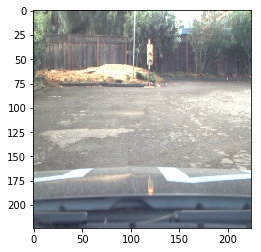

In [58]:
i = (int)(random.random() * len(img_paths))
img_path = img_paths[i]
print('Image Path: {}'.format(img_path))

img = cv2.resize(cv2.imread(img_path), (224, 224))
label = labels[i]

print('Image Shape: {}'.format(img.shape))
print('Image Label: {}'.format(label))
print('Image Class: {}'.format(
    'green' if label[0] else ('yellow' if label[1] else ('red' if label[2] else 'none'))))
plt.imshow(img[:,:,::-1])


pred = classifier_model.predict(img.reshape(1,224,224,3))[0]
print('Prediction: {}'.format(pred))
img_cls = np.argmax(pred)
print('Predicted Class: {}'.format(
    'green' if img_cls==0 else ('yellow' if img_cls==1 else ('red' if img_cls==2 else 'none'))))

### Saving the trained model

In [59]:
CLASSIFIER_MODEL_WEIGHTS_FILE = os.path.join('models', 'classifier_model_weights.h5')
CLASSIFIER_MODEL_YAML_FILE = os.path.join('models', 'classifier_model.yaml')

In [60]:
# Saving the weights
classifier_model.save_weights(CLASSIFIER_MODEL_WEIGHTS_FILE)

# Saving the architecture
classifier_model_yaml = classifier_model.to_yaml()
with open(CLASSIFIER_MODEL_YAML_FILE, "w") as classifier_yaml_file:
    classifier_yaml_file.write(classifier_model_yaml)